## Cleaning Comp Data

1 - Upload data

In [1]:
import pickle

# Upload data
infile = "../../LapSim_Validation/signal_dict.pkl"      ## !!! Replace with your file location !!! ##
with open(infile, "rb") as file:
    signal_dict = pickle.load(file)

In [2]:
list(signal_dict.keys())

['VC_Heartbeat',
 'VC_State',
 'VC_BuzzerOn',
 'VC_NumberOfCanDataLogs',
 'VC_CanLoggingRemainingErrors',
 'VC_Hash',
 'VC_Clean',
 'VC_RegenEnabled',
 'VC_TorqueVectoringEnabled',
 'VC_BatVoltage',
 'VC_BoostVoltage',
 'VC_AccVoltage',
 'VC_AccCurrent',
 'VC_BatCurrent',
 'VC_ShdnCurrent',
 'VC_ShdnStatus',
 'VC_LvCurrent',
 'VC_LvStatus',
 'VC_PumpCurrent',
 'VC_PumpStatus',
 'VC_AuxCurrent',
 'VC_AuxStatus',
 'VC_InvRCurrent',
 'VC_InvRStatus',
 'VC_InvLCurrent',
 'VC_InvLStatus',
 'VC_ImuAccelerationX',
 'VC_ImuAccelerationY',
 'VC_ImuAccelerationZ',
 'VC_LEStopOKStatus',
 'VC_REStopOKStatus',
 'VC_TSMSOKStatus',
 'VC_SplitterBoxInterlockOKStatus',
 'VC_FirstFaultNode',
 'VC_MappedPedalPercentage',
 'VC_Fault_MissingBMSHeartbeat',
 'VC_Fault_MissingFSMHeartbeat',
 'VC_Fault_MissingRSMHeartbeat',
 'VC_Fault_MissingCRITHeartbeat',
 'VC_Fault_LeftInverterFault',
 'VC_Fault_RightInverterFault',
 'VC_Fault_MissingBMSHeartbeatCount',
 'VC_Fault_MissingFSMHeartbeatCount',
 'VC_Fault_Missi

2 - Plot some of the data to see how it looks

Recall that these are the labels I'm looking for:

BMS:
* BMS_MaxCellTemperature
* BMS_MinCellTemperature
* BMS_ChargingCurrent
* BMS_PackVoltage
* BMS_SoC
* BMS_MinCellVoltage
* BMS_MaxCellVoltage
* BMS_TractiveSystemVoltage
* BMS_TractiveSystemCurrent
* BMS_TractiveSystemPower

INVL:
* INVL_CommandedTorque
* INVL_TorqueFeedback
* INVL_DcBusVoltage
* INVL_OutputVoltage
* INVL_DCBusCurrent
* INVL_MotorSpeed

INVR:
* INVR_CommandedTorque
* INVR_TorqueFeedback
* INVR_DcBusVoltage
* INVR_OutputVoltage
* INVR_DcBusCurrent
* INVR_MotorSpeed

Pull out the data from the required labels

In [3]:
# Create a class to better upload and update the data, hopefully making it easier to plot
import numpy as np
import datetime

class nestedDict:
    def __init__(self, inputDict, inputKey):
        self.name = inputKey
        self.date_time = inputDict[inputKey]["Time"]
        self.duration = np.array(inputDict[inputKey]["Duration"])
        self.value = np.array(inputDict[inputKey]["Value"])
        self.unit = inputDict[inputKey]["Unit"]

class newNestedDictEntry:
    def __init__(self, name):
        self.name = name
        self.date_time = None
        self.duration = None
        self.value = None
        self.unit = None

Plotting Function

In [4]:
import matplotlib.pyplot as plt

def plotVsTime(inputs, y_unit, title, xlimits=[None, None], ylimits=[None, None]):
    for i in range(0, len(inputs)):
        plt.plot(inputs[i].duration, inputs[i].value, label=inputs[i].name, linewidth=1)

    plt.legend()
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Duration (s)")
    plt.ylabel(y_unit)
    plt.xlim(xlimits)
    plt.ylim(ylimits)

    if " " in title:
        title = title.replace(" ", "_")
    filePath = "plots/" + title + ".png"
    plt.savefig(filePath)
    plt.show()

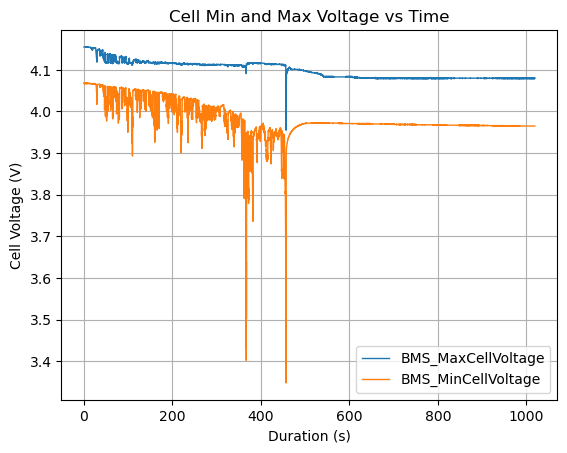

In [6]:
# min and max cell voltage
cellMaxVoltage = nestedDict(signal_dict, "BMS_MaxCellVoltage")
cellMinVoltage = nestedDict(signal_dict, "BMS_MinCellVoltage")

plotVsTime([cellMaxVoltage, cellMinVoltage], "Cell Voltage (V)", "Cell Min and Max Voltage vs Time")

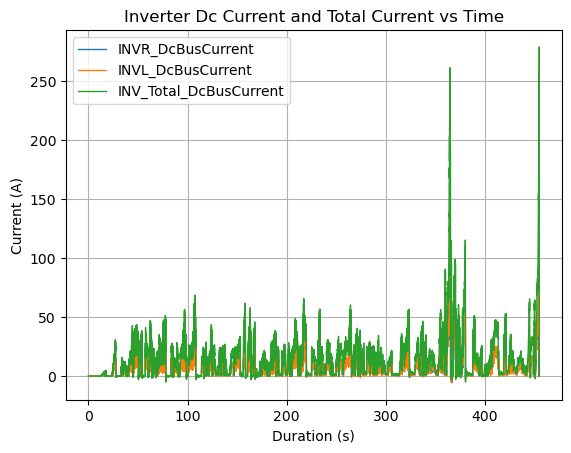

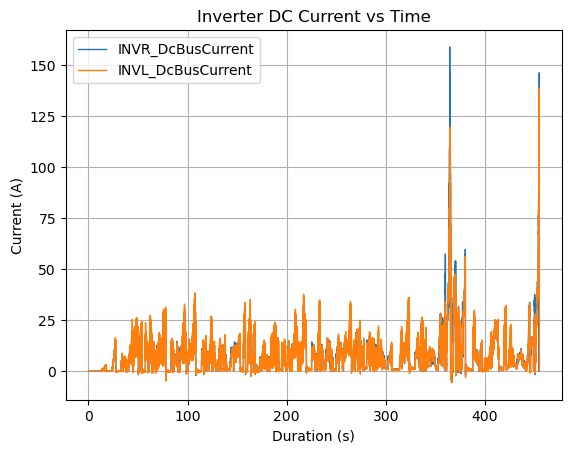

In [60]:
# Convert Data to Easier Format

INVR_DcCurrent = nestedDict(signal_dict, "INVR_DcBusCurrent")
INVL_DcCurrent = nestedDict(signal_dict, "INVL_DcBusCurrent")
INVTOT_DcCurrent = newNestedDictEntry("INV_Total_DcBusCurrent")

INVTOT_DcCurrent.duration = INVR_DcCurrent.duration
INVTOT_DcCurrent.value = INVL_DcCurrent.value[:-1] + INVR_DcCurrent.value   # to account for different sizes found while testing

plotVsTime([INVR_DcCurrent, INVL_DcCurrent, INVTOT_DcCurrent], "Current (A)", "Inverter Dc Current and Total Current vs Time")

plotVsTime([INVR_DcCurrent, INVL_DcCurrent], "Current (A)", "Inverter DC Current vs Time")

Plot Commanded Torque

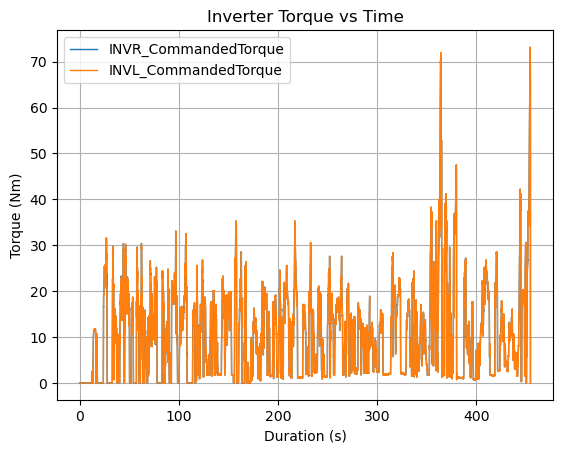

In [61]:
INVR_Torque = nestedDict(signal_dict, "INVR_CommandedTorque")
INVL_Torque = nestedDict(signal_dict, "INVL_CommandedTorque")

plotVsTime([INVR_Torque, INVL_Torque], "Torque (Nm)", "Inverter Torque vs Time")

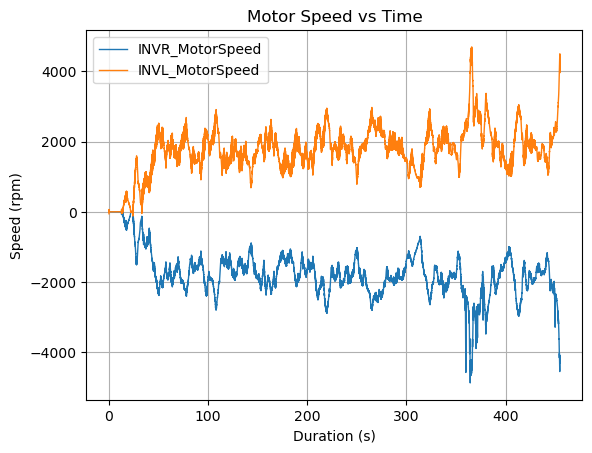

In [62]:
INVL_Speed = nestedDict(signal_dict, "INVL_MotorSpeed")
INVR_Speed = nestedDict(signal_dict, "INVR_MotorSpeed")

plotVsTime([INVR_Speed, INVL_Speed], "Speed (rpm)", "Motor Speed vs Time")

Inverter DC Current vs Tractive System Current

Conclusion: they're pretty much the same, but originally the current output from TS was negative

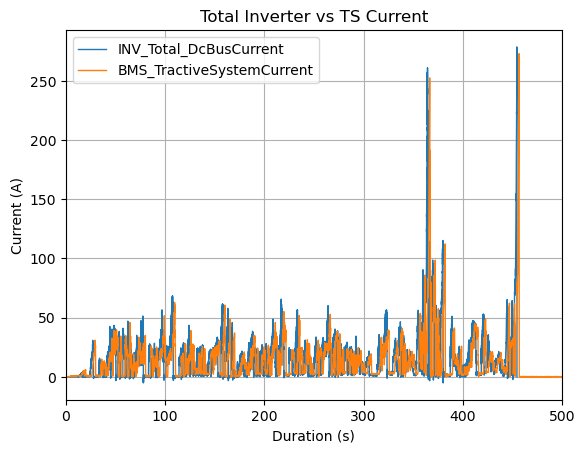

In [63]:
BMS_TSCurrent = nestedDict(signal_dict, "BMS_TractiveSystemCurrent")
BMS_TSCurrent.value = abs(BMS_TSCurrent.value)
end_index = np.searchsorted(BMS_TSCurrent.duration, 500)

plotVsTime([INVTOT_DcCurrent, BMS_TSCurrent], "Current (A)", "Total Inverter vs TS Current", xlimits=[0,500])

Commanded Torque vs Torque Feedback

Ok - so I think the commanded torque is positive for all, but the torque feedback is negative for a few. The commanded torque is less than the torque feedback too.

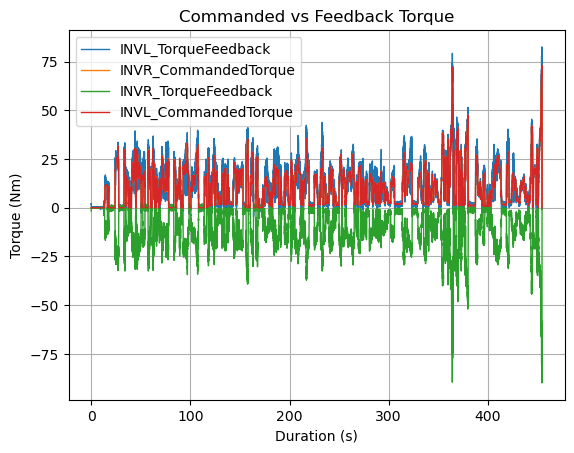

In [70]:
INVL_TFB = nestedDict(signal_dict, "INVL_TorqueFeedback")
INVR_TFB = nestedDict(signal_dict, "INVR_TorqueFeedback")

plotVsTime([INVL_TFB, INVR_Torque, INVR_TFB, INVL_Torque], "Torque (Nm)", "Commanded vs Feedback Torque")

Look into regen:

Conclusion: regen was not enabled during our endurance race

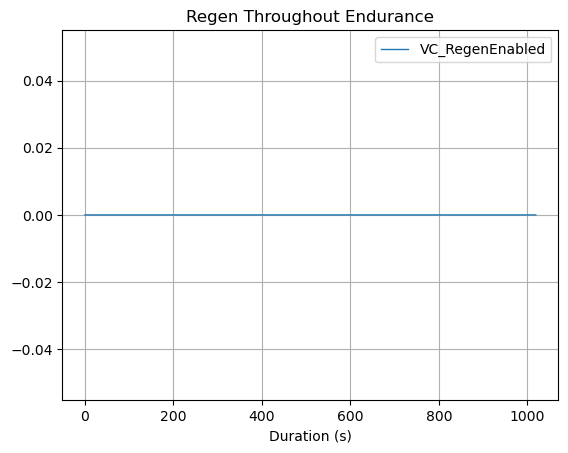

In [74]:
RegenOn = nestedDict(signal_dict, "VC_RegenEnabled")

plotVsTime([RegenOn], None, "Regen Throughout Endurance")

Look at Accumulator Voltage over Laps

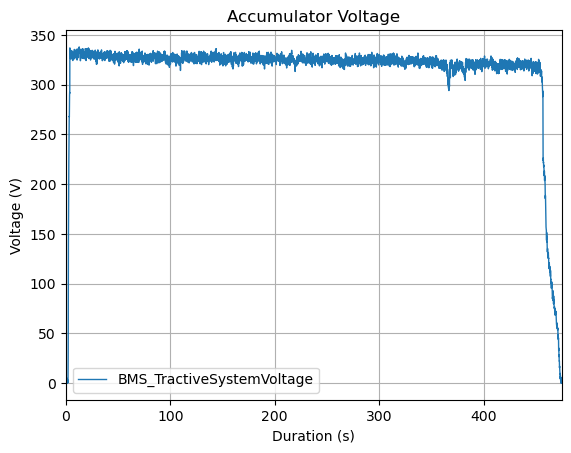

In [78]:
accVoltage = nestedDict(signal_dict, "BMS_TractiveSystemVoltage")
accVoltage2 = nestedDict(signal_dict, "BMS_PackVoltage")

plotVsTime([accVoltage], "Voltage (V)", "Accumulator Voltage", xlimits=[0,475])

Look at cell temperatures
* Appears that they are measured about once a second, but temperatures seem to stay constant for long swaths of time

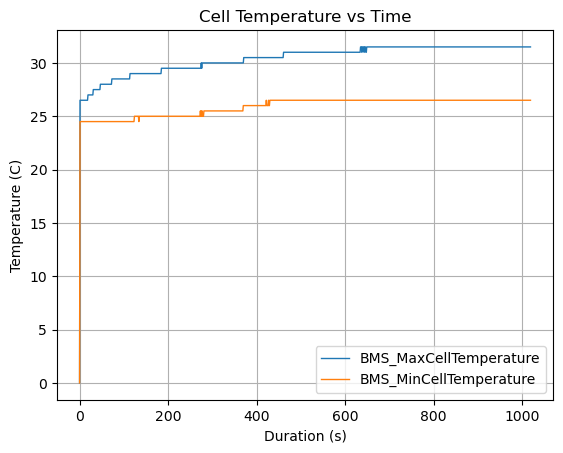

In [84]:
maxCellTemp = nestedDict(signal_dict, "BMS_MaxCellTemperature")
minCellTemp = nestedDict(signal_dict, "BMS_MinCellTemperature")

plotVsTime([maxCellTemp, minCellTemp], "Temperature (C)", "Cell Temperature vs Time")

SoC?

Appears that SoC drops from a little above 80 to about 75% in the span of 450 seconds of driving

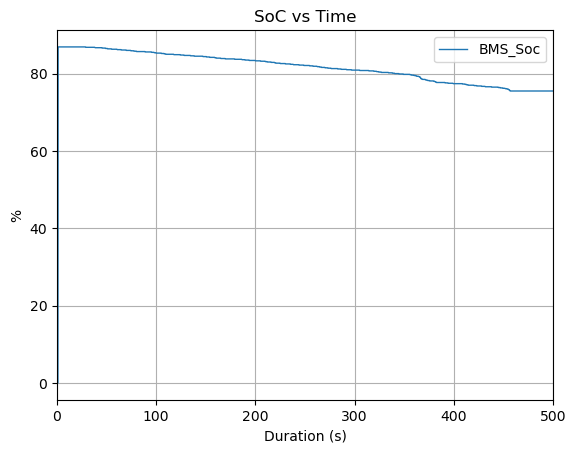

In [89]:
SoC = nestedDict(signal_dict, "BMS_Soc")

plotVsTime([SoC], "%", "SoC vs Time", xlimits=[0,500])

What about braking data?

Look at "FSM_BrakeActuated", "FSM_FrontBrakePressure", "FSM_RearBrakePressure"

Well... this shows that the brake was rarely ever on in the middle of the race meaning that Howard was mainly gliding

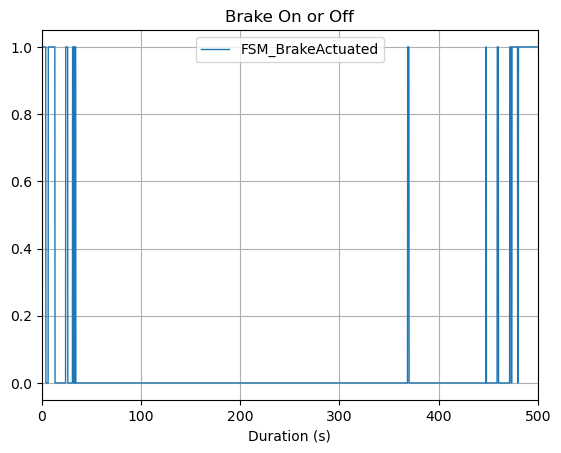

In [91]:
brakeOn = nestedDict(signal_dict, "FSM_BrakeActuated")

plotVsTime([brakeOn], None, "Brake On or Off", xlimits=[0,500])

Battery Power of Course!!! How could I forget!!!

BMS_TractiveSystemPower

Ok, so this shows that we are generally below 20 kW for the start of the slow driving. Then, when we started driving harder, we managed to pull 80 kW from the battery.

Current and power profiles match up - pattern-wise. Ok - the TS Power is just the multiplication of the battery voltage and current.

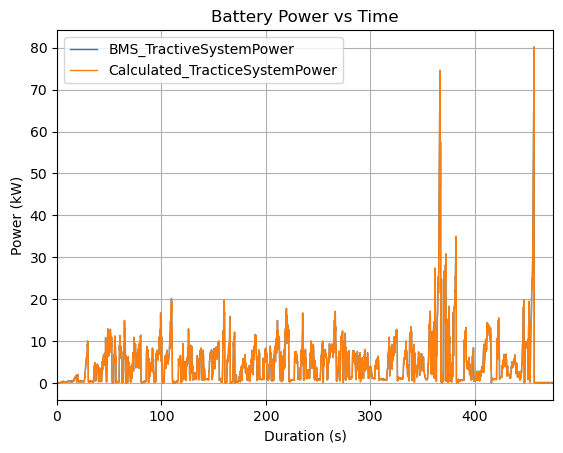

In [101]:
TSPower = nestedDict(signal_dict, "BMS_TractiveSystemPower")
TSPower.value = abs(TSPower.value)
TSCurrent = nestedDict(signal_dict, "BMS_TractiveSystemCurrent")
TSVoltage = nestedDict(signal_dict, "BMS_TractiveSystemVoltage")
calc_TSPower = newNestedDictEntry("Calculated_TracticeSystemPower")
calc_TSPower.value = abs(TSCurrent.value * TSVoltage.value) / 1000
calc_TSPower.duration = TSPower.duration

plotVsTime([TSPower, calc_TSPower], "Power (kW)", "Battery Power vs Time", xlimits=[0,475])

Next goals:
1) Filter Voltage data to see if there is a similar trend to my lap sim
2) Look at current data to determine if there is a similar trend to lap sim
3) From current --> voltage: plot together to determine if there's a similar trend to sim

**However, for all of these, I can't really compare since it's not the same pack or car...

4) Look for patterns to determine where each "lap" starts and ends?
    * Visually, it's hard to tell whether this will be possible...